
# Integrantes
---
- Brendo dos Santos Carvalho 	(202106840027)
- Carlos Augusto M Souza 		(201806840022)
- Joseph Frank Kwamina Abiw 	(201806840004)
- Prince Nyarko 			(202006840047)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, RepeatVector, SpatialDropout1D,LayerNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import unicodedata

2025-04-01 20:21:39.678625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743549699.691001  154909 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743549699.694679  154909 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743549699.704899  154909 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743549699.704915  154909 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743549699.704916  154909 computation_placer.cc:177] computation placer alr

In [2]:
# Preprocessing functions
def preprocess_text(text):
    # Normalize and clean text
    text = unicodedata.normalize('NFKD', text.lower()).encode('ASCII', 'ignore').decode('ASCII')
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [3]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load dataset
df = pd.read_csv('para_tourism_dataset.csv')

# Apply preprocessing
# df['input_clean'] = df['input'].apply(preprocess_text)
# df['response_clean'] = df['response'].apply(preprocess_text)
# df['input_clean'] = df['input'].apply(preprocess_text)
# df['response_clean'] = df['response'].apply(preprocess_text)

In [4]:
df.head()

,input,response
0,Descreva as características geográficas e a po...,Bragança é um município brasileiro situado no ...
1,Explique as diferentes versões sobre a fundaçã...,Existem pelo menos duas narrativas principais ...
2,Qual foi o papel da arqueologia em contrapor a...,"Por muito tempo, prevaleceu uma visão eurocênt..."
3,Descreva as características das sociedades ama...,Os estudos arqueológicos revelam que as socied...
4,Como o texto descreve o impacto da chegada dos...,O início da ocupação europeia na região de Bra...


In [5]:
# Tokenizer setup
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([df['input'], df['response']]))

vocab_size = len(tokenizer.word_index) + 1

In [6]:
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 2989


In [24]:
# Convert texts to sequences
input_sequences = tokenizer.texts_to_sequences(df['input'])
response_sequences = tokenizer.texts_to_sequences(df['response'])

# Pad sequences
max_length = max(max(len(seq) for seq in input_sequences), max(len(seq) for seq in response_sequences))
print(max_length)

input_padded = pad_sequences(input_sequences, maxlen=max_length, padding='post')
response_padded = pad_sequences(response_sequences, maxlen=max_length, padding='post')

# response_padded = tf.keras.utils.to_categorical(np.array(response_padded), num_classes=vocab_size)

138


In [56]:
# Improved Model Architecture
embedding_dim = 128  # Reduced from 256 to prevent overfitting
lstm_units = 256     # Reduced from 512

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    BatchNormalization(),  # Helps stabilize training
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(0.3),  # Randomly disable 30% of neurons to prevent over-reliance
    BatchNormalization(),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    BatchNormalization(),
    # Dense(vocab_size)
    Dense(vocab_size, activation='softmax')
])

# 2. Improved Training Configuration
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.build(input_shape=(None, max_length))  # (batch_size, sequence_length)
model.summary()

/home/prinako/External/School/UFPA/ITEC_UFPA/24.4_SEMESTER/INTELIGENCIA_COMPUTACIONAL/T2/amazon-portuguese-chatbot/venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 138, 128)       │       382,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 138, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 138, 512)       │       788,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 138, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 138, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 138, 512)       │     1,574,912 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 138, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 138, 2989)      │     1,533,357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,283,949 (16.34 MB)

 Trainable params: 4,281,645 (16.33 MB)

 Non-trainable params: 2,304 (9.00 KB)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5230 - loss: 6.9538
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7944 - loss: 4.8349
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8337 - loss: 3.4216
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8398 - loss: 2.3669
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8631 - loss: 1.4790
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8681 - loss: 1.2171
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8692 - loss: 1.1536
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8704 - loss: 1.1137
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8705 - loss: 1.1065
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8718 - loss: 1.0665
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8717 - loss: 1.0207
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy:

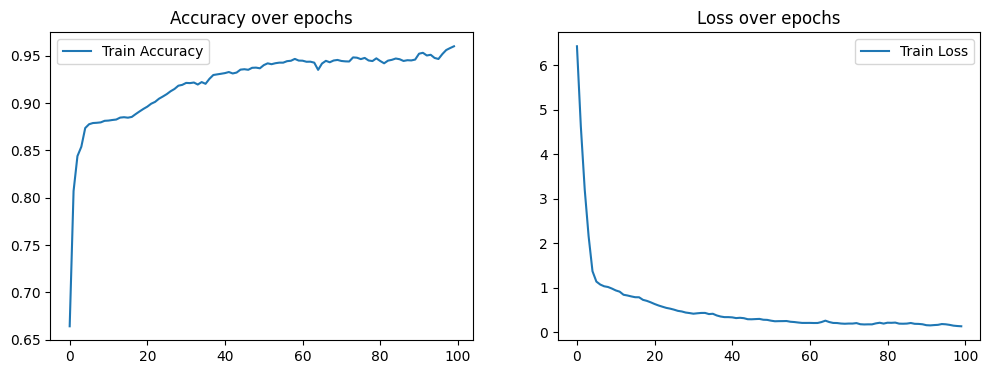

In [57]:
# 5. Training with both callbacks
history = model.fit(
    input_padded, response_padded,
    epochs=100,
    batch_size=64,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save('portuguese_chatbot_vl2.h5')

# Save the tokenizer
import pickle
with open('tokenizer_vl2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [62]:
def generate_response(input_text, temperature=0.75):
    # Preprocess input
    # cleaned_input = preprocess_text(input_text)
    cleaned_input = input_text
    input_seq = tokenizer.texts_to_sequences([cleaned_input])
    input_padded = pad_sequences(input_seq, maxlen=max_length, padding='post')
    
    # Initialize response
    response_seq = np.zeros((1, max_length))
    # response_seq[0, 0] = tokenizer.word_index['<OOV>']  # Start token
    
    for i in range(1, max_length):
        # Predict next word
        predictions = model.predict([input_padded, response_seq], verbose=0)[0][i-1]
        
        # Apply temperature for diversity
        predictions = np.clip(predictions,1e-10, 1.0)
        predictions = np.log(predictions) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)
        
        # Sample from predictions
        next_word_idx = np.random.choice(len(predictions), p=predictions)
        response_seq[0, i] = next_word_idx
        
        # Stop if end token is predicted
        if next_word_idx == 0:
            break
    
    
    # Convert sequence to text
    response_tokens = [tokenizer.index_word.get(idx, '') for idx in response_seq[0] if idx != 0]
    return ' '.join(response_tokens)

# Test the chatbot
test_inputs = [
    "olá",
    "como é o clima no pará?"
]

for input_text in test_inputs:
    response = generate_response(input_text)
    print(f"User: {input_text}")
    print(f"Chatbot: {response}\n")

User: olá
Chatbot: oi tudo bem estou para para falar falar a cultura e turismo do pará

User: como é o clima no pará?
Chatbot: o clima em belém é quente e úmido média 26°c com intensas de de dezembro dezembro a a novembro novembro é de chuvoso



In [66]:
def generate_response(input_text, temperature=0.9):
    """
    Generate a response to the input text using the trained model.
    
    Args:
        input_text: User input string
        temperature: Controls randomness of predictions (higher = more random)
        
    Returns:
        Generated response string
    """
    # Preprocess input
    # cleaned_input = preprocess_text(input_text)
    cleaned_input = input_text
    input_seq = tokenizer.texts_to_sequences([cleaned_input])
    input_padded = pad_sequences(input_seq, maxlen=max_length, padding='post')
    
    # Initialize response
    response_seq = np.zeros((1, max_length))
    # response_seq[0, 0] = tokenizer.word_index['<OOV>']  # Start token
    
    for i in range(1, max_length):
        # Predict next word
        predictions = model.predict([input_padded, response_seq], verbose=0)[0][i-1]
        
        # Apply temperature for diversity
        predictions = np.clip(predictions,1e-10, 1.0)
        predictions = np.log(predictions) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)
        
        # Sample from predictions
        next_word_idx = np.random.choice(len(predictions), p=predictions)
        response_seq[0, i] = next_word_idx
        
        # Stop if end token is predicted
        if next_word_idx == 0:
            break
    
    # Convert sequence to text
    response_tokens = []
    for idx in response_seq[0]:
        if idx == 0:  # Skip padding
            continue
        word = tokenizer.index_word.get(idx, '')
        if word == '<OOV>':  # Skip OOV tokens
            continue
        response_tokens.append(word)
    
    return ' '.join(response_tokens)

# Test the chatbot
test_inputs = [
    "oi",
    "conte me sobre o folclore",
    "quais frutas tem na amazônia?",
    "quem é o curupira?",
    "o que é Ver-o-Peso",
    "O que é a Iara?"
]

for input_text in test_inputs:
    response = generate_response(input_text)
    print(f"User: {input_text}")
    print(f"Chatbot: {response}\n")

User: oi
Chatbot: olá como posso você com com com com o belém pará

User: conte me sobre o folclore
Chatbot: o pará tacacá é é do do do localizado no de foi 1625 com sua belém da que e como resistência elementos

User: quais frutas tem na amazônia?
Chatbot: a torneio amazônia e principalmente do pará e e e

User: quem é o curupira?
Chatbot: o curupira é uma lenda do brasileiro brasileiro um de das florestas com vermelhos virados virados protege protege e floresta que confundir confundir

User: o que é Ver-o-Peso
Chatbot: o ver é peso é o famoso famoso famoso fundado serviços em 1625 um um um mercado de mercado peixe carne peixe feira

User: O que é a Iara?
Chatbot: a iara é uma sereia do do brasileiro que vive nos rios e encanta homens homens e seu

